In [1]:
from nba_api.stats.endpoints import leagueleaders
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from nba_api.stats.endpoints import leaguedashplayerstats, synergyplaytypes
from nba_api.stats.endpoints import teamyearbyyearstats, playercareerstats
from nba_api.stats.static.players import find_players_by_full_name, find_player_by_id

from matplotlib.offsetbox import OffsetImage, AnnotationBbox, DrawingArea, TextArea
from matplotlib.patches import Circle, FancyArrowPatch, FancyArrow, ArrowStyle, Arrow, Rectangle
import matplotlib.ticker as mtick
import time
from tqdm import tqdm
from sklearn.cluster import KMeans
import numpy as np
import functools
import seaborn as sns
import glob
from sklearn import preprocessing
from scipy import stats
from fitter import Fitter, get_common_distributions, get_distributions
import sklearn
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import gamma, exponpow, lognorm, cauchy, genhyperbolic
from datetime import date
from PIL import Image

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

/var/folders/wg/8c_xwvyn2tl18ply9w25rmgm0000gn/T/ipykernel_39453/3917013953.py:30: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
season = '2023-24'

scoring_types = ['Spotup', 'Isolation', 'Transition', 'Postup',]

play_types_dict = {}

for play_type in tqdm(scoring_types):
    
    type_players = synergyplaytypes.SynergyPlayTypes(league_id='00', per_mode_simple='PerGame', 
                                                          player_or_team_abbreviation='P',
                                                          season_type_all_star='Regular Season',
                                                          season='2023-24',
                                                          play_type_nullable=play_type,
                                                          type_grouping_nullable='offensive').get_data_frames()[0]
    
    play_types_dict[play_type] = type_players
    
    time.sleep(1)

100%|█████████████████████████████████████████████| 4/4 [00:07<00:00,  1.90s/it]


In [3]:
for i, (play_type, df_) in enumerate(play_types_dict.items()):
    # for j, column in enumerate(df.columns):
    #     print(j, column)
    
    # print(list(df.columns[8:]))
    
    df_names= list(df_.columns[6:])
    for df_name in df_names:
        df_.rename(columns = {df_name : f'{df_name}_{play_type}'}, inplace = True)

    # break

In [4]:
play_types_dict['Isolation']

,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,PLAY_TYPE_Isolation,TYPE_GROUPING_Isolation,PERCENTILE_Isolation,GP_Isolation,...,TOV_POSS_PCT_Isolation,SF_POSS_PCT_Isolation,PLUSONE_POSS_PCT_Isolation,SCORE_POSS_PCT_Isolation,EFG_PCT_Isolation,POSS_Isolation,PTS_Isolation,FGM_Isolation,FGA_Isolation,FGMX_Isolation
0,22023,1629029,Luka Doncic,1610612742,DAL,Dallas Mavericks,Isolation,Offensive,0.838,18,...,0.067,0.108,0.025,0.483,0.586,6.7,7.7,2.6,5.5,2.9
1,22023,1628369,Jayson Tatum,1610612738,BOS,Boston Celtics,Isolation,Offensive,0.819,19,...,0.071,0.101,0.030,0.485,0.576,5.2,6.0,2.2,4.5,2.3
2,22023,1628983,Shai Gilgeous-Alexander,1610612760,OKC,Oklahoma City Thunder,Isolation,Offensive,0.886,18,...,0.033,0.176,0.044,0.549,0.521,5.1,6.1,1.9,4.0,2.1
3,22023,201142,Kevin Durant,1610612756,PHX,Phoenix Suns,Isolation,Offensive,0.514,18,...,0.109,0.129,0.030,0.426,0.424,5.6,5.1,1.8,4.4,2.6
4,22023,203954,Joel Embiid,1610612755,PHI,Philadelphia 76ers,Isolation,Offensive,0.724,16,...,0.082,0.178,0.041,0.521,0.526,4.6,4.8,1.8,3.6,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,22023,1630581,Josh Giddey,1610612760,OKC,Oklahoma City Thunder,Isolation,Offensive,0.019,19,...,0.214,0.071,0.000,0.214,0.200,0.7,0.3,0.1,0.5,0.4
102,22023,1631128,Christian Braun,1610612743,DEN,Denver Nuggets,Isolation,Offensive,0.057,21,...,0.100,0.000,0.000,0.200,0.222,0.5,0.2,0.1,0.4,0.3
103,22023,1628372,Dennis Smith Jr.,1610612751,BKN,Brooklyn Nets,Isolation,Offensive,0.029,12,...,0.000,0.000,0.000,0.182,0.182,0.9,0.3,0.2,0.9,0.8
104,22023,1628381,John Collins,1610612762,UTA,Utah Jazz,Isolation,Offensive,0.029,20,...,0.091,0.000,0.000,0.182,0.200,0.6,0.2,0.1,0.5,0.4


In [5]:
dfs = list(play_types_dict.values())

names_to_group = []
for i, (play_type, df_) in enumerate(play_types_dict.items()):
    for j, column in enumerate(df_.columns):
        if j < 6:
            names_to_group.append(column)
        print(j, column)
        
    break
    
print(names_to_group)

0 SEASON_ID
1 PLAYER_ID
2 PLAYER_NAME
3 TEAM_ID
4 TEAM_ABBREVIATION
5 TEAM_NAME
6 PLAY_TYPE_Spotup
7 TYPE_GROUPING_Spotup
8 PERCENTILE_Spotup
9 GP_Spotup
10 POSS_PCT_Spotup
11 PPP_Spotup
12 FG_PCT_Spotup
13 FT_POSS_PCT_Spotup
14 TOV_POSS_PCT_Spotup
15 SF_POSS_PCT_Spotup
16 PLUSONE_POSS_PCT_Spotup
17 SCORE_POSS_PCT_Spotup
18 EFG_PCT_Spotup
19 POSS_Spotup
20 PTS_Spotup
21 FGM_Spotup
22 FGA_Spotup
23 FGMX_Spotup
['SEASON_ID', 'PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME']


In [6]:
dash_players = leaguedashplayerstats.LeagueDashPlayerStats(per_mode_detailed='PerGame',
                                                                    season='2023-24',
                                                                    season_type_all_star='Regular Season',
                                                                    measure_type_detailed_defense='Scoring').get_data_frames()[0]

time.sleep(1)

regular_stats = leaguedashplayerstats.LeagueDashPlayerStats(per_mode_detailed='PerGame', 
                                                                      season='2023-24', 
                                                                      season_type_all_star='Regular Season').get_data_frames()[0]
    

df_final = functools.reduce(lambda left, right: pd.merge(left, right, on=names_to_group, how='left'), dfs)

df_final = df_final.fillna(0)
df_final = pd.merge(df_final, dash_players, on=['PLAYER_ID', 'PLAYER_NAME'])
df_final = pd.merge(df_final, regular_stats, on=['PLAYER_ID', 'PLAYER_NAME'])

# df_final = df_final[(df_final['MIN'] > 25) & (df_final['GP'] > 40)]

for column in df_final.columns:
    print(column)

SEASON_ID
PLAYER_ID
PLAYER_NAME
TEAM_ID_x
TEAM_ABBREVIATION_x
TEAM_NAME
PLAY_TYPE_Spotup
TYPE_GROUPING_Spotup
PERCENTILE_Spotup
GP_Spotup
POSS_PCT_Spotup
PPP_Spotup
FG_PCT_Spotup
FT_POSS_PCT_Spotup
TOV_POSS_PCT_Spotup
SF_POSS_PCT_Spotup
PLUSONE_POSS_PCT_Spotup
SCORE_POSS_PCT_Spotup
EFG_PCT_Spotup
POSS_Spotup
PTS_Spotup
FGM_Spotup
FGA_Spotup
FGMX_Spotup
PLAY_TYPE_Isolation
TYPE_GROUPING_Isolation
PERCENTILE_Isolation
GP_Isolation
POSS_PCT_Isolation
PPP_Isolation
FG_PCT_Isolation
FT_POSS_PCT_Isolation
TOV_POSS_PCT_Isolation
SF_POSS_PCT_Isolation
PLUSONE_POSS_PCT_Isolation
SCORE_POSS_PCT_Isolation
EFG_PCT_Isolation
POSS_Isolation
PTS_Isolation
FGM_Isolation
FGA_Isolation
FGMX_Isolation
PLAY_TYPE_Transition
TYPE_GROUPING_Transition
PERCENTILE_Transition
GP_Transition
POSS_PCT_Transition
PPP_Transition
FG_PCT_Transition
FT_POSS_PCT_Transition
TOV_POSS_PCT_Transition
SF_POSS_PCT_Transition
PLUSONE_POSS_PCT_Transition
SCORE_POSS_PCT_Transition
EFG_PCT_Transition
POSS_Transition
PTS_Transition

In [7]:
df_final['PTS']

0      15.0
1      17.4
2      22.1
3      14.7
4      24.9
       ... 
297    12.2
298    11.4
299     9.2
300     3.4
301     3.5
Name: PTS, Length: 302, dtype: float64

In [8]:
for column in df_final.columns:
    if 'PTS' in column:
        print(column)

PTS_Spotup
PTS_Isolation
PTS_Transition
PTS_Postup
PCT_PTS_2PT
PCT_PTS_2PT_MR
PCT_PTS_3PT
PCT_PTS_FB
PCT_PTS_FT
PCT_PTS_OFF_TOV
PCT_PTS_PAINT
PCT_PTS_2PT_RANK
PCT_PTS_2PT_MR_RANK
PCT_PTS_3PT_RANK
PCT_PTS_FB_RANK
PCT_PTS_FT_RANK
PCT_PTS_OFF_TOV_RANK
PCT_PTS_PAINT_RANK
PTS
NBA_FANTASY_PTS
WNBA_FANTASY_PTS
PTS_RANK
NBA_FANTASY_PTS_RANK
WNBA_FANTASY_PTS_RANK


In [9]:
columns_to_keep = ['PLAYER_ID', 'PLAYER_NAME',
                   'PPP_Spotup', 'PPP_Isolation',
                   'PPP_Transition', 'PPP_Postup',
                   'PTS_Spotup', 'PTS_Isolation', 
                   'PTS_Transition', 'PTS_Postup', 'PTS'
                  ]

scorers = df_final[columns_to_keep]

scorers['Total_PTS'] = scorers.PTS_Spotup + scorers.PTS_Isolation + scorers.PTS_Transition + scorers.PTS_Postup

scorers['Total_PPP'] = scorers.PPP_Spotup + scorers.PPP_Isolation + scorers.PPP_Transition + scorers.PPP_Postup

sorted_top10_scorers = scorers.sort_values(by=['PTS'], ascending=False).round(2)[:10]

sorted_top10_scorers = sorted_top10_scorers[['PLAYER_NAME', 'PPP_Spotup', 'PPP_Isolation', 'PPP_Transition', 'PPP_Postup', 'PTS']]

sorted_top10_scorers

,PLAYER_NAME,PPP_Spotup,PPP_Isolation,PPP_Transition,PPP_Postup,PTS
159,Joel Embiid,1.17,1.06,1.29,1.06,32.0
170,Luka Doncic,1.12,1.16,1.24,0.86,31.4
40,Kevin Durant,1.38,0.90,1.26,0.82,31.0
102,De'Aaron Fox,1.00,1.17,1.09,0.00,30.3
161,Giannis Antetokounmpo,0.88,0.88,1.23,0.82,29.9
150,Shai Gilgeous-Alexander,1.02,1.20,1.26,1.37,29.9
186,Stephen Curry,1.11,1.17,1.17,0.00,29.1
157,Nikola Jokic,0.96,1.05,1.09,1.13,29.0
236,Devin Booker,0.96,0.92,1.28,1.54,27.9
42,Jayson Tatum,1.21,1.15,1.36,1.29,27.6


In [10]:
def ax_logo(player_id, ax):
    '''
    Plots the logo of the team at a specific axes.
    Args:
        team_id (int): the id of the team according to Fotmob. You can find it in the url of the team page.
        ax (object): the matplotlib axes where we'll draw the image.
    '''
    player_icon = Image.open(f'player_imgs/{player_id}.png')
    ax.imshow(player_icon)
    ax.axis('off')
    return ax

def get_player_img(player_id):
    #print(path)
    return OffsetImage(plt.imread(f'player_imgs/{player_id}.png'), zoom=zoom)

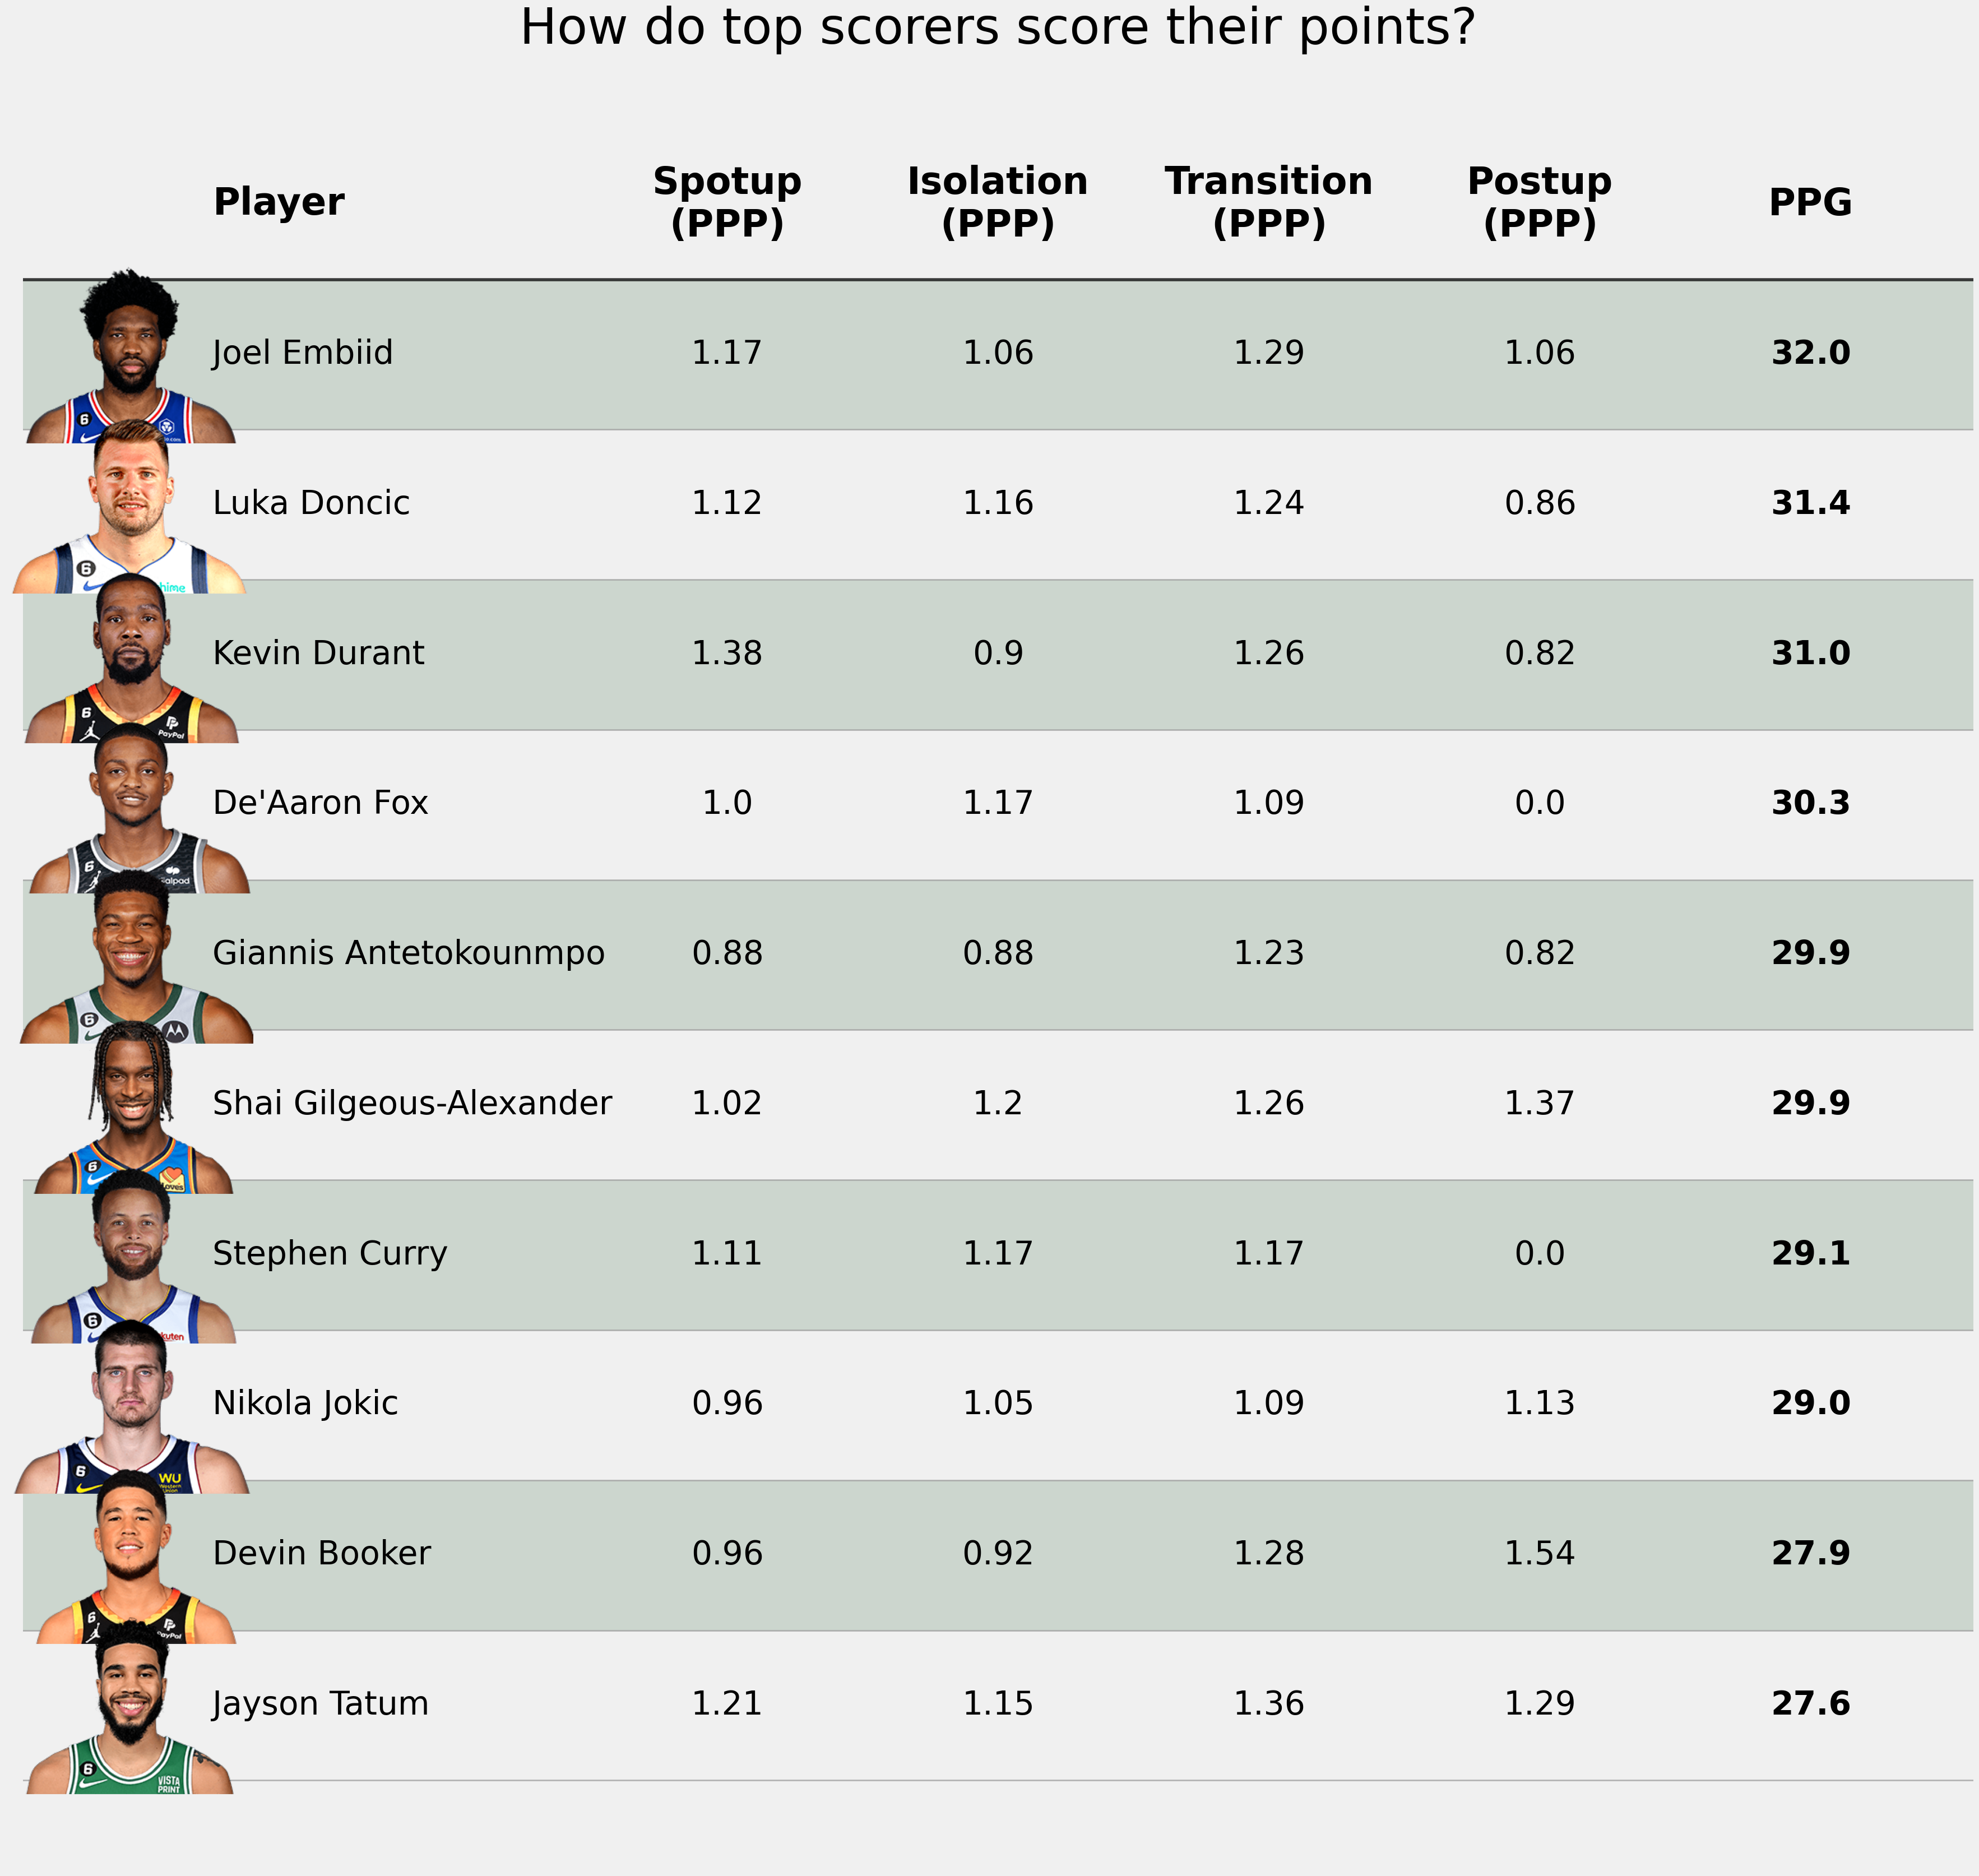

In [11]:
fig = plt.figure(figsize=(40,40))
ax = plt.subplot()

number_size = 42
font_size = 36
font_title = 48
title_size = 64
zoom = 1.2

top = len(sorted_top10_scorers)
for i in range(top):
    item = sorted_top10_scorers.iloc[i]
    try:
        player_id = find_players_by_full_name(item.PLAYER_NAME)[0]['id']
    except Exception:
        continue
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#CCD6CE'
        rect = Rectangle((-4.5, y_coord + 0.5), width=20, height=1, fill=True, color=color)
        ax.add_patch(rect)
    
    ab = AnnotationBbox(get_player_img(player_id), (0.1, y_coord), frameon=False)
    ax.add_artist(ab)
    #ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.SEASON, size=font_size)
    ax.text(x=0.25, y=y_coord, ha='left', va='center', s=item.PLAYER_NAME, size=number_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=12, color='#A0A0A0', alpha=0.75, lw=2)
    
    ax.text(x=1.2, y=y_coord, ha='center', va='center', s=f"{item.PPP_Spotup}", size=number_size)
    ax.text(x=1.7, y=y_coord, ha='center', va='center', s=f"{item.PPP_Isolation}", size=number_size)
    ax.text(x=2.2, y=y_coord, ha='center', va='center', s=f"{item.PPP_Transition}", size=number_size)
    ax.text(x=2.7, y=y_coord, ha='center', va='center', s=f"{item.PPP_Postup}", size=number_size)
    ax.text(x=3.2, y=y_coord, ha='center', va='center', s=f"{item.PTS}", size=number_size, weight='bold')
    
ax.text(x=0.25, y=top, s='Player', ha='left', va='center', size=font_title, weight='bold')
ax.text(x=1.2, y=top, ha='center', va='center', s="Spotup\n(PPP)", size=font_title, weight='bold')
ax.text(x=1.7, y=top, ha='center', va='center', s="Isolation\n(PPP)", size=font_title, weight='bold')
ax.text(x=2.2, y=top, ha='center', va='center', s="Transition\n(PPP)", size=font_title, weight='bold')
ax.text(x=2.7, y=top, ha='center', va='center', s="Postup\n(PPP)", size=font_title, weight='bold')
ax.text(x=3.2, y=top, ha='center', va='center', s="PPG", size=font_title, weight='bold')

ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("How do top scorers score their points?", size=title_size)
# plt.suptitle("(Top 10 players in points per game)", size=title_size-10, y=0.999)
    
ax.set_ylim(bottom=-1.1, top=top+1)
ax.set_xlim(left=-0.1, right=3.5)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.savefig('Graphs/best_scorers_2023.png', dpi=120, bbox_inches='tight')